In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

In [85]:
with h5py.File('/work/hmzhao/irregular-lc/roman-0-8dof-located-logsig.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X_even = torch.tensor(dataset_file['X_even'][...])
    X_rand = torch.tensor(dataset_file['X_random'][...])

# preprocess
nanind = torch.where(~torch.isnan(X_even[:, 0, 1]))[0]
Y = Y[nanind]

# discard uncertainty bar
X_even = X_even[nanind]
X_rand = X_rand[nanind]

print(len(Y))
# nanind = torch.where(Y[:, 4]>1e-4)[0]
# Y = Y[nanind]
# X_even = X_even[nanind]
# X_rand = X_rand[nanind]
# print(len(Y))

10000


In [86]:
# X_even[:, :, 1] = 22 - 2.5 * torch.log10(1000 * X_even[:, :, 1])
# X_rand[:, :, 1] = 22 - 2.5 * torch.log10(1000 * X_rand[:, :, 1])

tensor([4.2397e+01, 6.7652e+00, 9.5813e-02, 2.5359e-04, 7.5724e-01, 9.0358e-01,
        1.6124e+01, 1.2622e-01], dtype=torch.float64)


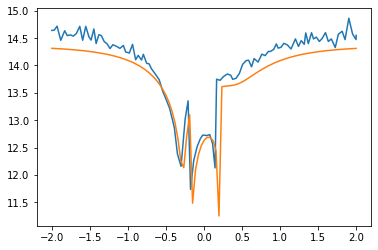

tensor([1.9988, 1.9988, 1.9988, 1.9988, 1.9988], dtype=torch.float64)
torch.Size([10000, 134, 5]) torch.Size([10000, 134, 5])


In [87]:
num = 0
print(Y[num])
# plt.xlim(-1.5, -0.5)
plt.plot(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.show()
print(X_even[num, -5:, 0])
print(X_even.shape, X_rand.shape)

tensor([4.2397e+01, 6.7652e+00, 9.5813e-02, 2.5359e-04, 7.5724e-01, 9.0358e-01,
        1.6124e+01, 1.2622e-01], dtype=torch.float64)


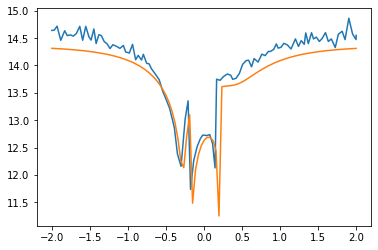

tensor([1.9988, 1.9988, 1.9988, 1.9988, 1.9988], dtype=torch.float64)
torch.Size([10000, 134, 5]) torch.Size([10000, 134, 5])


In [79]:
num = 0
print(Y[num])
# plt.xlim(-1.5, -0.5)
plt.plot(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.show()
print(X_even[num, -5:, 0])
print(X_even.shape, X_rand.shape)

In [88]:
X_even.shape

torch.Size([10000, 134, 5])

# CDE-MDN

In [2]:
import torchcde
with h5py.File('/work/hmzhao/irregular-lc/random-even-batch-1.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X_even = torch.tensor(dataset_file['X_even'][...])
    X_rand = torch.tensor(dataset_file['X_random'][...])
print(Y.shape)
# filter nan
nanind = torch.where(~torch.isnan(X_even[:, 0, 1]))[0]
Y = Y[nanind]
X_even = X_even[nanind]
X_rand = X_rand[nanind]
Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y = torch.hstack([Y, torch.sin(Y[:, [6]] / 180 * np.pi)])
Y[:, 6] = torch.cos(Y[:, 6] / 180 * np.pi)
print(Y.shape)
Y = Y[:, 2:]
print(Y.shape)
mean_y = torch.mean(Y, axis=0)
std_y = torch.std(Y, axis=0)
# std_mask = (std_y==0)
# std_y[std_mask] = 1
print(f'Y mean: {mean_y}\nY std: {std_y}')
mean_x_even = 14.5
std_x_even = 0.2
# X_even[:, :, 1] = 10**((22-X_even[:, :, 1])/2.5)/1000
# X_even[:, :, 1] = 22 - 2.5*torch.log10(1000*X_even[:, :, 1])
X_even[:, :, 1] = (X_even[:, :, 1] - mean_x_even) / std_x_even
X_rand[:, :, 1] = (X_rand[:, :, 1] - mean_x_even) / std_x_even
print(f'normalized X mean: {torch.mean(X_even[:, :, 1])}\nX std: {torch.mean(torch.std(X_even[:, :, 1], axis=0))}')

# time rescale
X_even[:, :, 0] = X_even[:, :, 0] / 200
X_rand[:, :, 0] = X_rand[:, :, 0] / 200
X_rand = X_rand[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 10; window_length_rand = 2
train_logsig = torchcde.logsig_windows(X_even, depth, window_length=window_length)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig)
train_logsig_rand = torchcde.logsig_windows(X_rand, depth, window_length=window_length_rand)
train_coeffs_rand = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig_rand)

torch.Size([100000, 7])
torch.Size([100000, 8])
torch.Size([100000, 6])
Y mean: tensor([ 0.4055, -3.0007, -0.9316,  0.0611, -0.0036,  0.0157],
       dtype=torch.float64)
Y std: tensor([0.2958, 0.5779, 0.6977, 0.2436, 0.7128, 0.7012], dtype=torch.float64)
normalized X mean: -2.0646457695410256
X std: 1.1980351190055827


In [62]:
import torchcde
X_even = torch.tensor(np.load('./KMT/0304.npy')).unsqueeze(0)
X_even[:, :, 1] = (X_even[:, :, 1] - 14.5) / 0.2
X_even[:, :, 0] = X_even[:, :, 0]
depth = 3; window_length = 5; window_length_rand = 2
train_logsig = torchcde.logsig_windows(X_even, depth, window_length=window_length)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig)

In [63]:
X_even.shape, train_logsig.shape

(torch.Size([1, 503, 2]), torch.Size([1, 102, 5]))

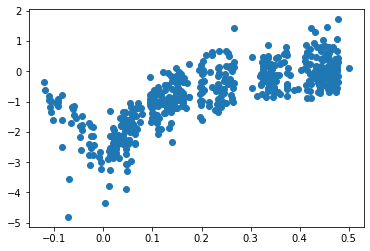

In [64]:
# plt.xlim(-0.1, 0.1)
plt.scatter(X_even[0, :, 0], X_even[0, :, 1])

In [60]:
X_even.shape

torch.Size([1, 503, 2])

In [61]:
# Y: t_0, t_E, u_0, rho, q, s, alpha, f_s
Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, 7] = torch.sin(Y[:, 6] / 180 * np.pi)
Y[:, 6] = torch.cos(Y[:, 6] / 180 * np.pi)
Y = Y[:, 2:]
mean_y = torch.mean(Y, axis=0)
std_y = torch.std(Y, axis=0)

NameError: name 'Y' is not defined

In [90]:
mean_x_even = 14.5
std_x_even = 0.2
# X_even[:, :, 1] = 10**((22-X_even[:, :, 1])/2.5)/1000
# X_even[:, :, 1] = 22 - 2.5*torch.log10(1000*X_even[:, :, 1])
X_even[:, :, 1] = (X_even[:, :, 1] - mean_x_even) / std_x_even
print(f'normalized X mean: {torch.mean(X_even[:, :, 1])}\nX std: {torch.mean(torch.std(X_even[:, :, 1], axis=0))}')
# X_rand = X_rand[:, :, :2]
# X_rand[:, :, 1] = 10**((22-X_rand[:, :, 1])/2.5)/1000
# X_rand[:, :, 1] = 22 - 2.5*torch.log10(1000*X_rand[:, :, 1])
X_rand[:, :, 1] = (X_rand[:, :, 1] - mean_x_even) / std_x_even

# time rescale
X_even[:, :, 0] = X_even[:, :, 0] / 4
X_rand[:, :, 0] = X_rand[:, :, 0] / 4

normalized X mean: -1.8614091520069842
X std: 1.5575743876676265


In [13]:
from model.locator import Locator
import torchcde
import os
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even)
train_coeffs_rand = torchcde.hermite_cubic_coefficients_with_backward_differences(X_rand)

NameError: name 'X_rand' is not defined

In [26]:
from model.cde_mdn import CDE_MDN
import torchcde
import os

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_00.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

# output_dim = Y.shape[-1]
output_dim = 6
input_dim = train_logsig.shape[-1]
# input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [7]:
def get_negloglik(pi, normal, y, withoutrho=False):
    # if withoutrho:
    #     normal = torch.distributions.Normal(normal.loc[:, :, [0, 2:]], normal.scale[:, :, [0, 2:]])
    loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
    loglik = torch.sum(loglik, dim=2)
    loss = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=1)
    return loss

In [94]:
from tqdm.notebook import tqdm
num = 4096
batchsize = 64
pred = torch.zeros((num, 6))
pred_rand = torch.zeros((num, 6))
nll = torch.zeros((num,))
nll_rand = torch.zeros((num,))
model.eval()
for i in tqdm(range(num // batchsize)):
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    batch_rand = train_coeffs_rand[i*batchsize:i*batchsize+batchsize].float().to(device)
    pi, normal = model(batch)
    pred[i*batchsize:i*batchsize+batchsize] = model.sample(pi, normal).detach().cpu()
    nll[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, Y[i*batchsize:i*batchsize+batchsize].float().to(device)).detach().cpu()
    pi, normal = model(batch_rand)
    pred_rand[i*batchsize:i*batchsize+batchsize] = model.sample(pi, normal)
    nll_rand[i*batchsize:i*batchsize+batchsize] = get_negloglik(pi, normal, Y[i*batchsize:i*batchsize+batchsize].float().to(device)).detach().cpu()

  0%|          | 0/64 [00:00<?, ?it/s]

In [95]:
num=4096
torch.mean((pred-Y[:num])**2, dim=0), torch.mean((pred_rand-Y[:num])**2, dim=0)

(tensor([0.0526, 0.6217, 0.0602, 0.0103, 0.1055, 0.1565], dtype=torch.float64),
 tensor([0.0585, 0.6216, 0.0665, 0.0113, 0.1307, 0.1735], dtype=torch.float64))

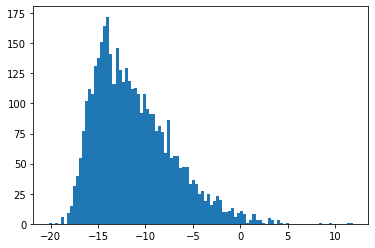

In [96]:
plt.hist(nll.numpy(), bins=100)
plt.show()

In [97]:
Y_filt = Y[torch.where(nll<0)]
pred_filt = pred[torch.where(nll<0)]

In [8]:
((pred-Y[:num])**2).argmax(dim=0)

tensor([ 239,  372,  556,  845,  574, 1862])

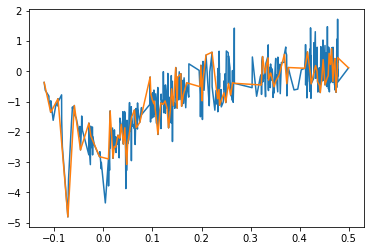

In [65]:
num = 0
# print(Y[num])
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.plot(train_logsig[num, :, 0], train_logsig[num, :, 1])
plt.show()

In [66]:
pi, normal = model(train_coeffs[[num]].float().to(device))

In [67]:
sample = model.sample(pi, normal).cpu().numpy()
print(sample)

[[ 1.122593   -3.1216135  -1.002865    0.2850877  -0.512462   -0.76898825]]


In [68]:
10**sample[:, 2]

array([0.09934249], dtype=float32)

In [69]:
from tqdm.notebook import tqdm
# qsnormal = torch.distributions.Normal(normal.loc[:, :, [0, 3]], normal.scale[:, :, [0, 3]])
qsnormal = torch.distributions.Normal(normal.loc[:, :, [2, 3]], normal.scale[:, :, [2, 3]])
grid = torch.stack(torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
# grid = torch.stack(torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
prob = torch.zeros(10000, 1)
# y = torch.tile(Y[[num]], [10000, 1])
# y[:, 2:4] = grid
for i in tqdm(range(10000)):
    prob[i] = torch.exp(-model.mdn_loss(pi, qsnormal, grid[[i]].to(device)).detach().cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [70]:
pi.probs

tensor([[7.4536e-04, 5.2023e-04, 1.9664e-04, 2.0820e-08, 1.4560e-04, 1.3279e-04,
         1.1111e-03, 2.8419e-03, 7.6467e-05, 9.9402e-01, 1.6551e-04, 4.3210e-05]],
       device='cuda:4', grad_fn=<SoftmaxBackward>)

In [71]:
Y[num], pred[num], model.sample(pi, normal)

NameError: name 'Y' is not defined

In [72]:
normal.loc, normal.scale

(tensor([[[ 1.0674, -3.1085, -0.2688, -0.0062,  0.9122, -0.0121],
          [ 1.0442, -2.9055, -0.3871, -0.1841, -0.2921,  0.8309],
          [ 1.2788, -2.8000, -1.0643,  0.5235, -0.3990, -0.1679],
          [ 0.3814, -3.2804, -0.0651,  0.3699,  0.1801,  0.7682],
          [ 1.1421, -3.1283, -0.2333, -0.0039, -0.0752,  0.9218],
          [-0.9272, -2.8918, -2.1575,  0.3254, -0.4467,  0.9100],
          [ 1.0344, -3.1679, -0.8546,  0.3322, -0.6412, -0.7886],
          [ 1.1299, -3.0232, -0.2865, -0.1574,  0.0318, -0.1678],
          [ 0.7548, -2.9548, -0.6066,  0.3572,  0.6418, -0.6859],
          [ 1.2244, -3.0168, -0.9786,  0.3113, -0.4591, -0.8145],
          [ 1.0052, -3.2541, -0.6622,  0.2631, -0.1226, -0.8212],
          [ 1.1064, -3.1858, -0.6072,  0.1940, -0.8208, -0.3181]]],
        device='cuda:4', grad_fn=<TransposeBackward0>),
 tensor([[[0.0832, 0.5436, 0.1580, 0.0377, 0.0321, 0.1112],
          [0.1001, 0.4709, 0.2439, 0.0554, 0.1880, 0.1029],
          [1.0356, 0.4701, 0.7

In [73]:
# torch.exp(-model.mdn_loss(pi, normal, Y[[num]].to(device)).detach().cpu()), \
torch.exp(-model.mdn_loss(pi, normal, model.sample(pi, normal).to(device)).detach().cpu())

tensor(1076.4674)

[[ 1.122593   -3.1216135  -1.002865    0.2850877  -0.512462   -0.76898825]]


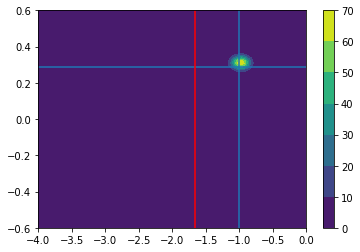

In [75]:
# plt.imshow(prob.reshape(100, 100), origin='lower')
x, y = torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100))
# x, y = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100))
plt.contourf(x, y, prob.reshape(100, 100))
# plt.contourf(torch.linspace(0, 1, 100), torch.linspace(-0.6, 0.6, 100), prob.reshape(100, 100).T)
# plt.hlines(Y[num, 3], 0, 1, colors='red')
# plt.vlines(Y[num, 0], -0.6, 0.6, colors='red')
# plt.hlines(sample[0, 3], 0, 1)
# plt.vlines(sample[0, 0], -0.6, 0.6)
plt.hlines(sample[num, 3], -4, 0)
plt.vlines(sample[num, 2], -0.6, 0.6)
plt.vlines(np.log10(0.022), -0.6, 0.6, color='red')
plt.colorbar()
# print(Y[num])
print(sample)

NameError: name 'Y' is not defined

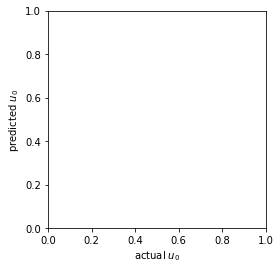

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
num=4096
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'actual $u_0$')
plt.ylabel(r'predicted $u_0$')
plt.scatter(Y[:num, 0], pred_rand.numpy()[:num, 0], s=5, c=-nll_rand[:num], cmap='Blues')
plt.scatter(Y[:num, 0], pred.numpy()[:num, 0], s=5, c=-nll[:num], cmap='Oranges')
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 0])
print(pred.numpy()[:10, 0])
print('mse of u_0: ', torch.mean((Y[:num, 0] -  pred.numpy()[:num, 0])**2, dim=0).detach().cpu().item())
print('mse of rand u_0: ', torch.mean((Y[:num, 0] -  pred_rand.numpy()[:num, 0])**2, dim=0).detach().cpu().item())

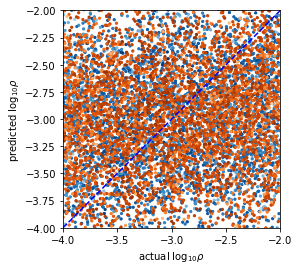

tensor([-3.5959, -2.5286, -2.7346, -2.0375, -2.1874, -3.5694, -3.7888, -3.6309,
        -2.9585, -2.2183], dtype=torch.float64)
[-4.1068873 -2.578882  -3.657215  -2.1479378 -3.85356   -2.4914536
 -2.753847  -4.1911106 -3.1970577 -3.3600414]
mse of log10rho:  0.6216527359817466
mse of rand log10rho:  0.6215944214546725


In [107]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-4, -2)
plt.ylim(-4, -2)
plt.xlabel(r'actual $\log_{10}\rho$')
plt.ylabel(r'predicted $\log_{10}\rho$')
plt.scatter(Y[:num, 1], pred_rand.numpy()[:num, 1], s=5, c=-nll_rand[:num], cmap='Blues')
plt.scatter(Y[:num, 1], pred.numpy()[:num, 1], s=5, c=-nll[:num], cmap='Oranges')
plt.plot(np.linspace(-4, -2), np.linspace(-4, -2), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 1])
print(pred.numpy()[:10, 1])
print('mse of log10rho: ', torch.mean((Y[:num, 1] -  pred.numpy()[:num, 1])**2, dim=0).detach().cpu().item())
print('mse of rand log10rho: ', torch.mean((Y[:num, 1] -  pred_rand.numpy()[:num, 1])**2, dim=0).detach().cpu().item())

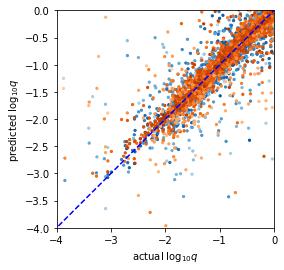

tensor([-0.1208, -0.0102, -1.4074, -0.2965, -0.2156, -1.0420, -0.4660, -0.1056,
        -0.9527, -0.5973], dtype=torch.float64)
[-0.17380768  0.01845124 -1.395315   -0.18026304 -0.17482617 -0.9191274
 -0.47696674 -0.14590475 -1.0059884  -0.6271548 ]
mse of log10q:  0.060226390090500015
mse of rand log10q:  0.06645003467431178


In [108]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 2], pred_rand.numpy()[:num, 2], s=5, c=-nll_rand[:num], cmap='Blues')
plt.scatter(Y[:num, 2], pred.numpy()[:num, 2], s=5, c=-nll[:num], cmap='Oranges')
plt.plot(np.linspace(-6, 0), np.linspace(-6, 0), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 2])
print(pred.numpy()[:10, 2])
print('mse of log10q: ', torch.mean((Y[:num, 2] -  pred.numpy()[:num, 2])**2, dim=0).detach().cpu().item())
print('mse of rand log10q: ', torch.mean((Y[:num, 2] -  pred_rand.numpy()[:num, 2])**2, dim=0).detach().cpu().item())

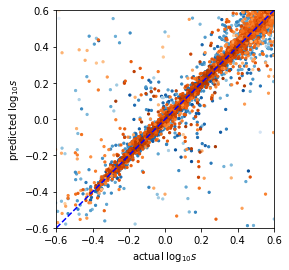

tensor([-0.0440,  0.4385,  0.2697,  0.5758,  0.6063,  0.0480, -0.1569,  0.4915,
         0.0552, -0.0653], dtype=torch.float64)
[-0.05141454  0.43996757  0.2801882   0.64342546  0.5624617   0.02547046
 -0.15505725  0.6329014   0.06810245 -0.08391812]
mse of log10s:  0.010304023415446667
mse of rand log10s:  0.011311518005915058


In [109]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(Y[:num, 3], pred_rand.numpy()[:num, 3], s=5, c=-nll_rand[:num], cmap='Blues')
plt.scatter(Y[:num, 3], pred.numpy()[:num, 3], s=5, c=-nll[:num], cmap='Oranges')
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 3])
print(pred.numpy()[:10, 3])
print('mse of log10s: ', torch.mean((Y[:num, 3] -  pred.numpy()[:num, 3])**2, dim=0).detach().cpu().item())
print('mse of rand log10s: ', torch.mean((Y[:num, 3] -  pred_rand.numpy()[:num, 3])**2, dim=0).detach().cpu().item())

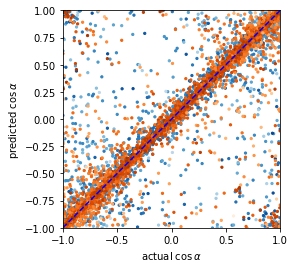

tensor([ 0.9607,  0.8167, -0.8623, -0.8144,  0.8535, -0.1275, -0.9728, -0.8144,
         0.3287, -0.7598], dtype=torch.float64)
[ 0.95302945 -0.8379281  -0.8722372  -0.81094     0.9416813  -0.11988156
 -0.9703087  -0.56865275  0.34140283 -0.70151645]
mse of cosa:  0.10547775575019361
mse of rand cosa:  0.1306770870668107


In [110]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(r'actual $\cos\alpha$')
plt.ylabel(r'predicted $\cos\alpha$')
plt.scatter(Y[:num, 4], pred_rand.numpy()[:num, 4], s=5, c=-nll_rand[:num], cmap='Blues')
plt.scatter(Y[:num, 4], pred.numpy()[:num, 4], s=5, c=-nll[:num], cmap='Oranges')
plt.plot(np.linspace(-1, 1), np.linspace(-1, 1), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 4])
print(pred.numpy()[:10, 4])
print('mse of cosa: ', torch.mean((Y[:num, 4] -  pred.numpy()[:num, 4])**2, dim=0).detach().cpu().item())
print('mse of rand cosa: ', torch.mean((Y[:num, 4] -  pred_rand.numpy()[:num, 4])**2, dim=0).detach().cpu().item())

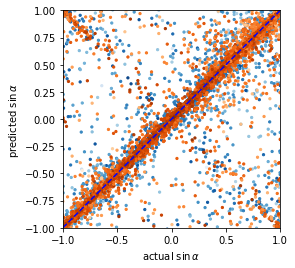

tensor([ 0.2777, -0.5770, -0.5065, -0.5803,  0.5211,  0.9918, -0.2315, -0.5803,
         0.9444,  0.6502], dtype=torch.float64)
[ 0.3458442   0.55721474 -0.49916178 -0.56397814  0.37380317  0.98096776
 -0.20253143 -0.779021    0.93689173  0.706623  ]
mse of sina:  0.15648452716601322
mse of rand sina:  0.17353093792102742


In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(r'actual $\sin\alpha$')
plt.ylabel(r'predicted $\sin\alpha$')
plt.scatter(Y[:num, 5], pred_rand.numpy()[:num, 5], s=5, c=-nll_rand[:num], cmap='Blues')
plt.scatter(Y[:num, 5], pred.numpy()[:num, 5], s=5, c=-nll[:num], cmap='Oranges')
plt.plot(np.linspace(-1, 1), np.linspace(-1, 1), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 5])
print(pred.numpy()[:10, 5])
print('mse of sina: ', torch.mean((Y[:num, 5] -  pred.numpy()[:num, 5])**2, dim=0).detach().cpu().item())
print('mse of rand sina: ', torch.mean((Y[:num, 5] -  pred_rand.numpy()[:num, 5])**2, dim=0).detach().cpu().item())

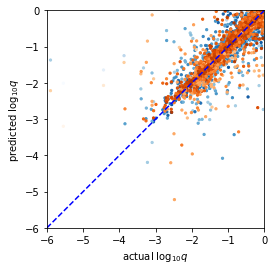

tensor([-0.1208, -0.0102, -1.4074, -0.2965, -0.2156, -1.0420, -0.4660, -0.1056,
        -0.9527, -0.5973], dtype=torch.float64)
[-0.17380768  0.01845124 -1.395315   -0.18026304 -0.17482617 -0.9191274
 -0.47696674 -0.14590475 -1.0059884  -0.6271548 ]
mse of log10q:  0.060226390090500015
mse of rand log10q:  0.06645003467431178


In [112]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-6, 0)
plt.ylim(-6, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 2], pred_rand.numpy()[:num, 2], s=5, c=-nll_rand[:num], cmap='Blues')
plt.scatter(Y[:num, 2], pred.numpy()[:num, 2], s=5, c=-nll[:num], cmap='Oranges')
plt.plot(np.linspace(-6, 0), np.linspace(-6, 0), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 2])
print(pred.numpy()[:10, 2])
print('mse of log10q: ', torch.mean((Y[:num, 2] -  pred.numpy()[:num, 2])**2, dim=0).detach().cpu().item())
print('mse of rand log10q: ', torch.mean((Y[:num, 2] -  pred_rand.numpy()[:num, 2])**2, dim=0).detach().cpu().item())

# UNet Locator and CNN Scaler

In [14]:
with h5py.File('/work/hmzhao/irregular-lc/roman-0-8dof.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X_even = torch.tensor(dataset_file['X_even'][...])
    X_rand = torch.tensor(dataset_file['X_random'][...])

In [15]:
# preprocess
nanind = torch.where(~torch.isnan(X_even[:, 0, 1]))[0]
# Y: t_0, t_E, u_0, rho, q, s, alpha, f_s
# Y = Y[:, [0, 1, -1]] # locator predicts t_0, t_E and f_s
Y[:, -1] = torch.log10(Y[:, -1])
std_Y = torch.tensor([1,])
# Y = Y / std_Y
Y = Y[nanind]
Y = Y[:, [0, 1, -1]]

# discard uncertainty bar
X_even = X_even[nanind]
X_rand = X_rand[nanind]

tensor([49.8670,  1.9257, -0.3953], dtype=torch.float64)


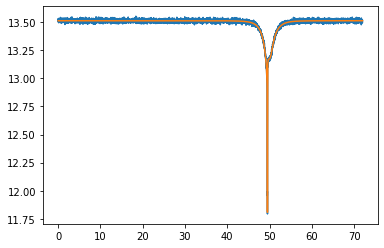

In [16]:
num = 933
print(Y[num])
plt.plot(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.show()

In [133]:
import torchcde
X_even = torch.tensor(np.load('./KMT/0414.npy')).unsqueeze(0)
X_even[:, :, 1] = (X_even[:, :, 1] - 20) / 0.2
X_even[:, :, 0] = X_even[:, :, 0]

In [134]:
from model.locator import Locator
import torchcde
import os

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/locator/experiment_24294.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

depth = 2; window_length = 1; 
train_logsig = torchcde.logsig_windows(X_even[:, :, :], depth, window_length=window_length)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig)

# output_dim = Y.shape[-1]
output_dim = 2
input_dim = train_logsig.shape[-1]
latent_dim = ckpt_args.latents

model = Locator(input_dim, latent_dim, output_dim, device).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

Locator(
  (unet): UNET_1D(
    (AvgPool1D1): AvgPool1d(kernel_size=(1,), stride=(5,), padding=(0,))
    (AvgPool1D2): AvgPool1d(kernel_size=(1,), stride=(25,), padding=(0,))
    (AvgPool1D3): AvgPool1d(kernel_size=(1,), stride=(125,), padding=(0,))
    (layer1): Sequential(
      (0): conbr_block(
        (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(3,))
        (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): PReLU(num_parameters=1)
      )
      (1): re_block(
        (cbr1): conbr_block(
          (conv1): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
          (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu): PReLU(num_parameters=1)
        )
        (cbr2): conbr_block(
          (conv1): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
          (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track

In [135]:
from model.scaler import Scaler
import torchcde
import os

device_s = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/scaler/experiment_76990.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

# depth = 2; window_length = 1; 
# train_rand_logsig = torchcde.logsig_windows(X_rand[:, :, :2], depth, window_length=window_length)
# train_rand_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_rand_logsig)

output_dim = 1
# input_dim = train_rand_logsig.shape[-1]
input_dim = train_logsig.shape[-1]
latent_dim = ckpt_args.latents

model_s = Scaler(input_dim, latent_dim, output_dim, device).to(device_s)
model_dict = model_s.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model_s.load_state_dict(state_dict)
model_s.to(device)

Scaler(
  (initial): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=1024, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=1024, out_features=32, bias=True)
    )
  )
  (gate): PReLU(num_parameters=1)
  (cnn_featurizer): Sequential(
    (0): Conv1d(32, 256, kernel_size=(15,), stride=(2,), padding=(7,))
    (1): PReLU(num_parameters=1)
    (2): Conv1d(256, 256, kernel_size=(15,), stride=(2,), padding=(7,))
    (3): PReLU(num_parameters=1)
    (4): Conv1d(256, 512, kernel_size=(15,), stride=(2,), padding=(7,))
    (5): PReLU(num_parameters=1)
    (6): CNNResBlock(
      (linear1): Conv1d(512, 128, kernel_size=(1,), stride=(1,), padding_mode=replicate)
      (nonlinear1): PReLU(num_parameters=1)
      (linear2): Conv1d(128, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=replicate)
      (layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (7): CNNResBlock(
      (linear1): Conv1d(512, 128, k

In [8]:
# animation of locator
from tqdm.notebook import tqdm
import matplotlib.animation as animation
# fig, ax = plt.subplots()
num = 5
z = torch.zeros((1, 4000)).to(device)
model.eval()
model.animate = True
ims = []
lc = []
for i in tqdm(range(2, 100)):
    batch = X_even[[num], :(7200*i//100), :]
    batch_line = torchcde.hermite_cubic_coefficients_with_backward_differences(batch).float().to(device)
    pred, mse, z_pred = model(batch_line, z)
    lc.append((batch[:, :, 1], z_pred.detach().cpu()))

    # im = ax.plot(batch[:, :, 1], animated=True)
    # im.append(ax.plot(z_pred.detach().cpu(), animated=True))
    # ims.append(im)

# ani = animation.ArtistAnimation(fig, ims)
# plt.show()                
np.save('ani.npy', lc)   
model.animate = False         

  0%|          | 0/98 [00:00<?, ?it/s]

In [18]:
from tqdm.notebook import tqdm
num = 4096*2
batchsize = 128
pred = torch.zeros((num, 2))
pred_s = torch.zeros((num, 1))
pred_rand = torch.zeros((num, 2))
pred_rand_s = torch.zeros((num, 1))
z = torch.zeros((batchsize, 4000)).to(device)
model.eval()
model.threshold = 0.5
model_s.eval()
for i in tqdm(range(num // batchsize)):
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    batch_rand = train_rand_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    # batch_y = Y[i*batchsize:i*batchsize+batchsize].float().to(device)
    # rescaley = (batch_y / 72 * 4000).int()
    # left = rescaley[:, [0]] - 2*rescaley[:, [1]]
    # right = rescaley[:, [0]] + 2*rescaley[:, [1]]
    # z = torch.tile(torch.arange(0, 4000).unsqueeze(0), (len(batch_y), 1)).to(device)
    # z = ((z > left) * (z < right)).int()
    pred[i*batchsize:i*batchsize+batchsize] = model(batch, z)[0].detach().cpu()
    pred_s[i*batchsize:i*batchsize+batchsize] = model_s(batch).detach().cpu()
    pred_rand[i*batchsize:i*batchsize+batchsize] = model(batch_rand, z)[0].detach().cpu()
    pred_rand_s[i*batchsize:i*batchsize+batchsize] = model_s(batch_rand).detach().cpu()

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

/home/hmzhao/.conda/envs/ode-rnn/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


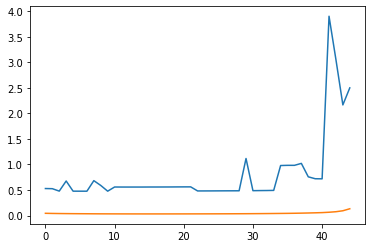

In [17]:
mse = []
for threshold in tqdm(np.arange(0.1, 1, 0.02)):
    model.threshold = threshold
    num = 4096
    batchsize = 128
    pred = torch.zeros((num, output_dim))
    z = torch.zeros((batchsize, 4000)).to(device)
    model.eval()
    for i in range(num // batchsize):
        batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
        pred[i*batchsize:i*batchsize+batchsize] = model(batch, z)[0].detach().cpu()
    mse.append(torch.mean((Y[:num] -  pred.numpy()[:num])**2, dim=0).detach().cpu().numpy())
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(mse)
plt.show()

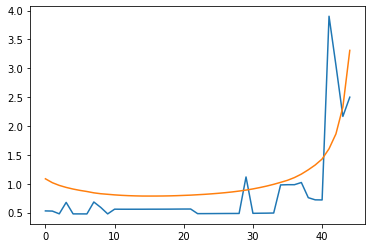

In [20]:
plt.plot(np.array(mse)[:, 0])
plt.plot(np.array(mse)[:, 1]*25)
plt.show()

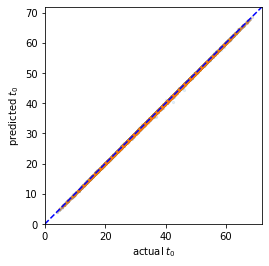

tensor([42.3968, 52.4625, 28.9251, 20.2984, 31.0619, 24.4573, 52.9314, 58.4026,
        55.2998, 15.6580], dtype=torch.float64)
[42.38588  52.595688 28.995153 20.280905 31.093166 24.417366 52.962204
 58.482086 55.36982  15.638773]
mse of t_0  0.011262589893124439
mse of t_0  0.016967052868603977


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
num=4096
plt.axis('square')
plt.xlim(0, 72)
plt.ylim(0, 72)
plt.xlabel(r'actual $t_0$')
plt.ylabel(r'predicted $t_0$')
plt.scatter(Y[:num, 0], pred_rand.numpy()[:num, 0], s=5, alpha=0.1)
plt.scatter(Y[:num, 0], pred.numpy()[:num, 0], s=5, alpha=0.1)
plt.plot(np.linspace(0, 72), np.linspace(0, 72), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 0])
print(pred.numpy()[:10, 0])
print('mse of t_0 ', torch.mean((Y[:num, 0] -  pred.numpy()[:num, 0])**2, dim=0).detach().cpu().item())
print('mse of t_0 ', torch.mean((Y[:num, 0] -  pred_rand.numpy()[:num, 0])**2, dim=0).detach().cpu().item())

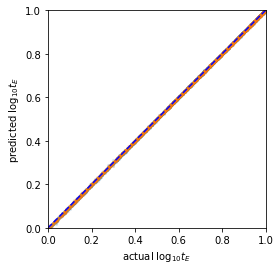

tensor([6.7652, 4.5947, 3.6902, 1.5346, 4.6416, 2.5067, 4.6210, 4.2347, 2.4163,
        5.1449], dtype=torch.float64)
[6.7499943 4.590276  3.6901278 1.5297418 4.636806  2.4978168 4.622057
 4.226536  2.4299746 5.152336 ]
mse of t_E:  0.00038278232155824127
mse of rand t_E:  0.00045385543687548926


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'actual $\log_{10}t_E$')
plt.ylabel(r'predicted $\log_{10}t_E$')
plt.scatter(np.log10(Y[:num, 1]), np.log10(pred_rand.numpy()[:num, 1]), s=5, alpha=0.1)
plt.scatter(np.log10(Y[:num, 1]), np.log10(pred.numpy()[:num, 1]), s=5, alpha=0.1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 1])
print(pred.numpy()[:10, 1])
print('mse of t_E: ', torch.mean((Y[:num, 1] -  pred.numpy()[:num, 1])**2, dim=0).detach().cpu().item())
print('mse of rand t_E: ', torch.mean((Y[:num, 1] -  pred_rand.numpy()[:num, 1])**2, dim=0).detach().cpu().item())

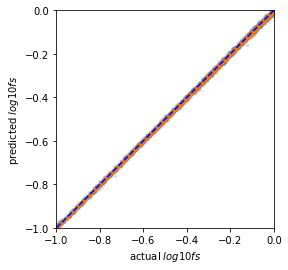

tensor([-0.8989, -0.5394, -0.1018, -0.3560, -0.8361, -0.6228, -0.3883, -0.3019,
        -0.5866, -0.5470], dtype=torch.float64)
[-0.8980586  -0.54251254 -0.09086222 -0.35387814 -0.8360581  -0.62563616
 -0.3915188  -0.3025544  -0.5821252  -0.55416006]
mse of log_10 f_s:  1.8719825004168105e-05
mse of rand log_10 f_s:  4.575172800991186e-05


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-1, 0)
plt.ylim(-1, 0)
plt.xlabel(r'actual $log10fs$')
plt.ylabel(r'predicted $log10fs$')
plt.scatter(Y[:num, 2], pred_rand_s.numpy()[:num, 0], s=5, alpha=0.1)
plt.scatter(Y[:num, 2], pred_s.numpy()[:num, 0], s=5, alpha=0.1)
plt.plot(np.linspace(-1, 0), np.linspace(-1, 0), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 2])
print(pred_s.numpy()[:10, 0])
print('mse of log_10 f_s: ', torch.mean((Y[:num, 2] -  pred_s.numpy()[:num, 0])**2, dim=0).detach().cpu().item())
print('mse of rand log_10 f_s: ', torch.mean((Y[:num, 2] -  pred_rand_s.numpy()[:num, 0])**2, dim=0).detach().cpu().item())

In [22]:
mse = torch.mean((Y[:num] -  torch.hstack([pred, pred_s]).numpy()[:num])**2, dim=0).detach().cpu()

In [23]:
loglik = -0.5 * np.log(2*np.pi*mse) - 0.5 * mse / mse

In [24]:
loglik.sum()

tensor(7.3633, dtype=torch.float64)

In [25]:
loglik.sum() + 12

tensor(19.3633, dtype=torch.float64)

In [19]:
((Y[:num, 2] -  pred_s.numpy()[:num, 0])**2).argmax()

tensor(1269)

In [11]:
with h5py.File('/work/hmzhao/irregular-lc/random-even-batch-1.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X_even = torch.tensor(dataset_file['X_even'][...])

In [53]:
# normalize
Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, 7] = torch.sin(Y[:, 6] / 180 * np.pi)
# Y = torch.hstack([Y, torch.sin(Y[:, [6]] / 180 * np.pi)])
Y[:, 6] = torch.cos(Y[:, 6] / 180 * np.pi)
Y = Y[:, 2:]
# mean_y = torch.mean(Y, axis=0)
# std_y = torch.std(Y, axis=0)
# std_mask = (std_y==0)
# std_y[std_mask] = 1
# print(f'Y mean: {mean_y}\nY std: {std_y}')
# Y = (Y - mean_y) / std_y
# print(f'normalized Y mean: {torch.mean(Y)}\nY std: {torch.mean(torch.std(Y, axis=0)[~std_mask])}')

mean_x_even = 14.5
std_x_even = 0.2
X_even[:, :, 1] = (X_even[:, :, 1] - mean_x_even) / std_x_even
print(f'normalized X mean: {torch.mean(X_even[:, :, 1])}\nX std: {torch.mean(torch.std(X_even[:, :, 1], axis=0))}')
X_even[:, :, 0] = X_even[:, :, 0] / 200

# X_even[:, :, 1] = (22-2.5*torch.log10(X_even[:, :, 1]*1000)-14.5)/0.2
# print(f'normalized X mean: {torch.mean(X_even[:, :, 1])}\nX std: {torch.mean(torch.std(X_even[:, :, 1], axis=0))}')
# X_even[:, :, 0] = X_even[:, :, 0] / 4


# Y = Y[:, 4:6]

normalized X mean: -1.0703994295747723
X std: 0.9875648277714473


tensor([ 1.0327, -3.4003, -0.9039,  0.6157, -0.8839, -0.4677],
       dtype=torch.float64)


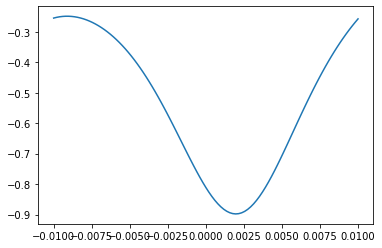

In [54]:
print(Y[5])
plt.plot(X_even[5, :, 0], X_even[5, :, 1])

# CDE Regression

In [55]:
from model.encoder_cde import CDEEncoder
import torchcde
import os

device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/experiment_1.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

depth = 3; window_length = 10; window_length_rand = 2
# train_logsig = torchcde.logsig_windows(X_even[:, :, :], depth, window_length=window_length)
# train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even)

output_dim = Y.shape[-1]
# input_dim = train_logsig.shape[-1]
input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDEEncoder(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDEEncoder(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (ReLU1): ReLU()
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): ReLU()
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): ReLU()
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): ReLU()
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (ReLU2): ReLU()
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=160, out_features=160, bias=True)
  )
  (initial): Sequential(
    (0): Sequential

In [56]:
from tqdm import tqdm
num = 4096*2
batchsize = 128
pred = torch.zeros((num, output_dim))
model.eval()
for i in tqdm(range(num // batchsize)):
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    pred[i*batchsize:i*batchsize+batchsize] = model(batch).detach().cpu()

100%|██████████| 64/64 [03:54<00:00,  3.66s/it]


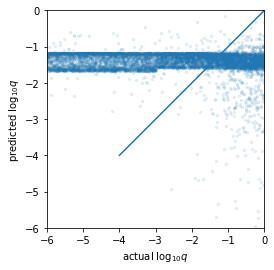

logq


In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.axis('square')
plt.xlim(-6, 0)
plt.ylim(-6, 0)
plt.xlabel(r'actual $\log_{10} q$')
plt.ylabel(r'predicted $\log_{10} q$')
plt.scatter(Y[:num, 2], pred.numpy()[:num, 2], s=5, alpha=0.1)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0))
plt.show()
print('logq')

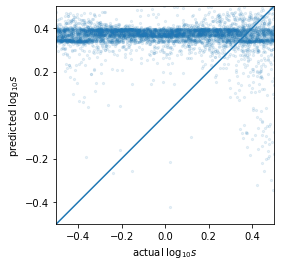

logs


In [61]:
# num = 4096*5
plt.axis('square')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel(r'actual $\log_{10} s$')
plt.ylabel(r'predicted $\log_{10} s$')
plt.scatter(Y[:num, 3], pred.numpy()[:, 3], s=5, alpha=0.1)
plt.plot(np.linspace(-0.5, 0.5), np.linspace(-0.5, 0.5))
plt.show()
print('logs')

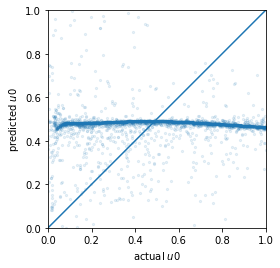

u0


In [62]:
# num = 4096*5
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'actual $u0$')
plt.ylabel(r'predicted $u0$')
plt.scatter(Y[:num, 0], pred.numpy()[:, 0], s=5, alpha=0.1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1))
plt.show()
print('u0')

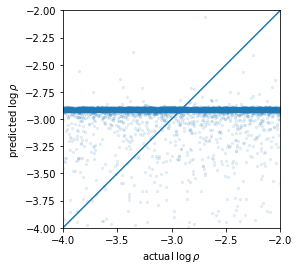

logrho


In [63]:
# num = 4096*5
plt.axis('square')
plt.xlim(-4, -2)
plt.ylim(-4, -2)
plt.xlabel(r'actual $\log\rho$')
plt.ylabel(r'predicted $\log\rho$')
plt.scatter(Y[:num, 1], pred.numpy()[:, 1], s=5, alpha=0.1)
plt.plot(np.linspace(-4, -2), np.linspace(-4, -2))
plt.show()
print('logrho')

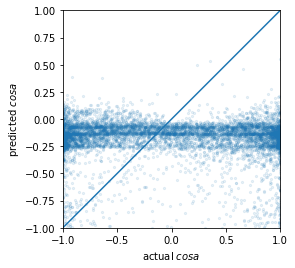

cosa


In [64]:
plt.axis('square')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(r'actual $cosa$')
plt.ylabel(r'predicted $cosa$')
plt.scatter(Y[:num, 4], pred.numpy()[:, 4], s=5, alpha=0.1)
plt.plot(np.linspace(-1, 1), np.linspace(-1, 1))
plt.show()
print('cosa')

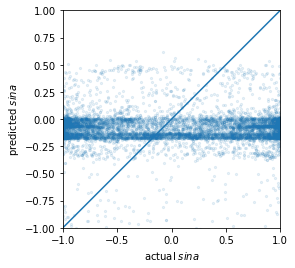

sina


In [65]:
plt.axis('square')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel(r'actual $sina$')
plt.ylabel(r'predicted $sina$')
plt.scatter(Y[:num, 5], pred.numpy()[:, 5], s=5, alpha=0.1)
plt.plot(np.linspace(-1, 1), np.linspace(-1, 1))
plt.show()
print('sina')

In [66]:
torch.mean((Y[:num, 0] - pred[:, 0])**2)

tensor(9.0990, dtype=torch.float64)

In [67]:
# orig_sample_Y = Y[:num] * std_y + mean_y
# orig_sample_pred = pred.detach().cpu() * std_y + mean_y

In [68]:
u0 = Y[:num, 0]
# log10q = orig_sample_Y[:, 4] / np.log(10)
# log10s = orig_sample_Y[:, 5] / np.log(10)
# alpha = orig_sample_Y[:, 6]
u0cosalpha = u0 * Y[:num, 4]
u0sinalpha = u0 * Y[:num, 5]

log10q = Y[:num, 2]
log10s = Y[:num, 3]

u0_pred = pred[:, 0]
# log10q_pred = orig_sample_pred[:, 4] / np.log(10)
# log10s_pred = orig_sample_pred[:, 5] / np.log(10)
# alpha_pred = orig_sample_pred[:, 6]
u0cosalpha_pred = u0_pred * pred[:num, 4]
u0sinalpha_pred = u0_pred * pred[:num, 5]
log10q_pred = pred[:num, 2]
log10s_pred = pred[:num, 3]
log10s_pred_fl = ((Y[:num, 3]*pred.numpy()[:,3]<0)*(-2)+1)*pred.numpy()[:, 3]

In [69]:
mse_log10q = torch.mean((log10q - log10q_pred)**2)
mse_log10s = torch.mean((log10s - log10s_pred)**2)
mse_log10s_fl = torch.mean((log10s - log10s_pred_fl)**2)
mse_u0cos = torch.mean((u0cosalpha - u0cosalpha_pred)**2)
mse_cos = torch.mean((Y[:num, 4] - pred[:num, 4])**2)
mse_u0sin = torch.mean((u0sinalpha - u0sinalpha_pred)**2)
mse_sin = torch.mean((Y[:num, 5] - pred[:num, 5])**2)
mse_u0 = torch.mean((u0 - u0_pred)**2)
# mse_alpha = torch.mean((alpha - alpha_pred)**2)
print(f"mse of log10q: {mse_log10q}, mse of log10s: {mse_log10s}, mse of log10s flipped: {mse_log10s_fl}")
print(f"mse of u0cos_alpha: {mse_u0cos}, mse of u0sin_alpha: {mse_u0sin}")
print(f"mse of u0: {mse_u0}, mse of cosa: {mse_cos}, mse of sina: {mse_sin}")

mse of log10q: 16.573236655518137, mse of log10s: 85.69670099231229, mse of log10s flipped: 85.26849139749766
mse of u0cos_alpha: 96577.68685704867, mse of u0sin_alpha: 4581205.036823822
mse of u0: 9.099017679815294, mse of cosa: 26.67980783408025, mse of sina: 1033.7992157035346


## irregular

In [74]:
with h5py.File('/work/hmzhao/irregular-lc/random-even-batch-1.h5', mode='r') as dataset_file:
    X_rand = torch.tensor(dataset_file['X_random'][...])

In [75]:
X_rand = X_rand[:, :, :2]
X_rand[:, :, 1] = (X_rand[:, :, 1] - mean_x_even) / std_x_even
X_rand[:, :, 0] = X_rand[:, :, 0] / 200
print(f'normalized X mean: {torch.mean(X_rand[:, :, 1])}\nX std: {torch.mean(torch.std(X_rand[:, :, 1], axis=0))}')

normalized X mean: -2.069411861275131
X std: 1.2975609646921018


tensor([ 0.4230, -3.5956, -0.4956, -0.2005,  0.1277,  0.9918],
       dtype=torch.float64)


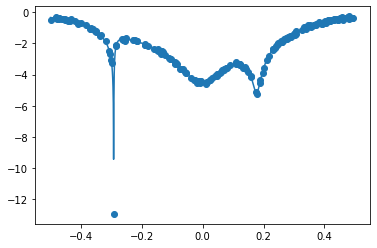

In [76]:
num = 1
print(Y[num])
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

In [77]:
num = 4096*2
batchsize = 128
train_logsig_rand = torchcde.logsig_windows(X_rand[:num, :, :], depth, window_length=window_length_rand)
train_rand_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig_rand)

In [78]:
from tqdm import tqdm
pred_ir = torch.zeros((num, output_dim))
model.eval()
for i in tqdm(range(num // batchsize)):
    batch = train_rand_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    pred_ir[i*batchsize:i*batchsize+batchsize] = model(batch).detach().cpu()

 19%|█▉        | 12/64 [01:35<06:54,  7.96s/it]


KeyboardInterrupt: 

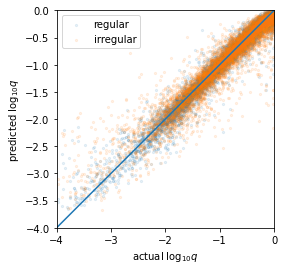

logq


In [74]:
num = 4096*2
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10} q$')
plt.ylabel(r'predicted $\log_{10} q$')
plt.scatter(Y[:num, 0]/np.log(10), pred.numpy()[:num, 0]/np.log(10), label='regular', s=5, alpha=0.1)
plt.scatter(Y[:num, 0]/np.log(10), pred_ir.numpy()[:num, 0]/np.log(10), label='irregular', s=5, alpha=0.1)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0))
plt.legend()
plt.show()
print('logq')

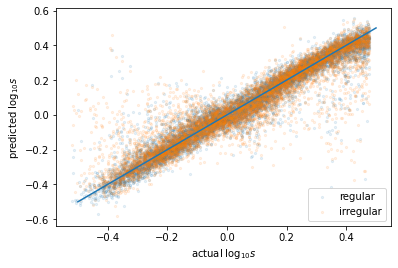

logs


In [73]:
plt.xlabel(r'actual $\log_{10} s$')
plt.ylabel(r'predicted $\log_{10} s$')
plt.scatter(Y[:num, 1]/np.log(10), pred.numpy()[:num, 1]/np.log(10), label='regular', s=5, alpha=0.1)
plt.scatter(Y[:num, 1]/np.log(10), pred_ir.numpy()[:num, 1]/np.log(10), label='irregular', s=5, alpha=0.1)
plt.plot(np.linspace(-0.5, 0.5), np.linspace(-0.5, 0.5))
plt.legend()
plt.show()
print('logs')

In [24]:
# orig_sample_pred_ir = pred_ir.detach().cpu() * std_y + mean_y

# u0_pred_ir = orig_sample_pred_ir[:, 2]
# log10q_pred_ir = orig_sample_pred_ir[:, 4] / np.log(10)
# log10s_pred_ir = orig_sample_pred_ir[:, 5] / np.log(10)
# alpha_pred_ir = orig_sample_pred_ir[:, 6]
# u0cosalpha_pred_ir = u0_pred_ir * np.cos(alpha_pred_ir/180*np.pi)
# u0sinalpha_pred_ir = u0_pred_ir * np.sin(alpha_pred_ir/180*np.pi)

log10q_pred_ir = pred_ir[:, 0] / np.log(10)
log10s_pred_ir = pred_ir[:, 1] / np.log(10)

In [25]:
mse_log10q_ir = torch.mean((log10q - log10q_pred_ir)**2)
mse_log10s_ir = torch.mean((log10s - log10s_pred_ir)**2)
# mse_u0cos_ir = torch.mean((u0cosalpha - u0cosalpha_pred_ir)**2)
# mse_u0sin_ir = torch.mean((u0sinalpha - u0sinalpha_pred_ir)**2)
# mse_u0_ir = torch.mean((u0 - u0_pred_ir)**2)
# mse_alpha_ir = torch.mean((alpha - alpha_pred_ir)**2)
print('regular:')
print(f"mse of log10q: {mse_log10q}, mse of log10s: {mse_log10s}")
# print(f"mse of u0cos_alpha: {mse_u0cos}, mse of u0sin_alpha: {mse_u0sin}")
# print(f"mse of u0: {mse_u0}, mse of alpha: {mse_alpha}")
print('irregular:')
print(f"mse of log10q: {mse_log10q_ir}, mse of log10s: {mse_log10s_ir}")
# print(f"mse of u0cos_alpha: {mse_u0cos_ir}, mse of u0sin_alpha: {mse_u0sin_ir}")
# print(f"mse of u0: {mse_u0_ir}, mse of alpha: {mse_alpha_ir}")

regular:
mse of log10q: 0.022074238500991727, mse of log10s: 0.00522088770891074
irregular:
mse of log10q: 0.05360115068172922, mse of log10s: 0.009940048005258264


Ground Truth: [-2.68066621  1.09161808]
Reg Pred [-3.0919013  1.002171 ]
Reg MSE [0.03189691 0.00150904]
Irr Pred [-3.318852   1.0125068]
Irr MSE [0.07681794 0.00118044]


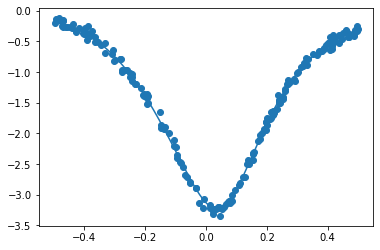

In [26]:
num = 0
print('Ground Truth:', Y[num].numpy())
print('Reg Pred', pred[num].numpy())
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy())
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

Ground Truth: [-0.49557534 -0.20045365]
Reg Pred [-0.5124909  -0.19459671]
Reg MSE [2.86137265e-04 3.43037549e-05]
Irr Pred [-0.4695378  -0.16875184]
Irr MSE [0.00067795 0.001005  ]


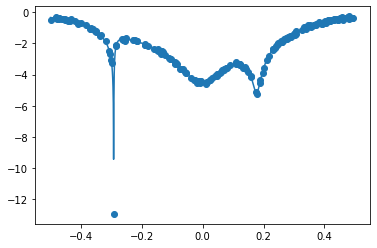

In [27]:
num = 1
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

In [28]:
torch.argmax(((Y[:4096*2] - pred)**2)[:,0])

tensor(6461)

Ground Truth: [-3.85518735 -0.0100205 ]
Reg Pred [-2.3501029e+00 -1.0784054e-03]
Reg MSE [2.26527920e+00 7.99610904e-05]
Irr Pred [-1.673176  -0.0958605]
Irr MSE [4.76117332 0.0073685 ]


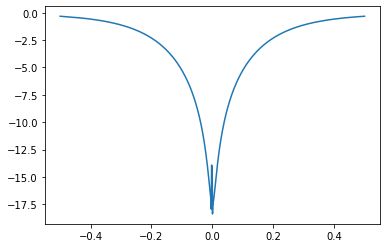

In [29]:
num = 6461
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

In [30]:
torch.argmax(((Y[:4096*2] - pred)**2)[:,1])

tensor(1412)

Ground Truth: [-1.09113109 -0.50749415]
Reg Pred [-1.7544608  0.3015215]
Reg MSE [0.44000632 0.65450634]
Irr Pred [-2.0741465   0.23478006]
Irr MSE [0.96631932 0.550971  ]


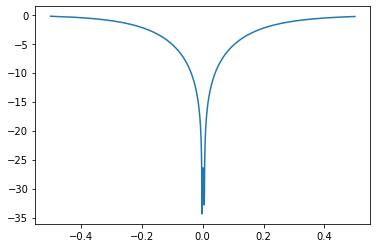

In [32]:
num = 1412
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

Ground Truth: [-0.0272697  -0.45959017]
Reg Pred [-0.7392516  -0.36684895]
Reg MSE [0.50691824 0.00860093]
Irr Pred [-2.389151    0.05758382]
Irr MSE [5.57848372 0.26746894]


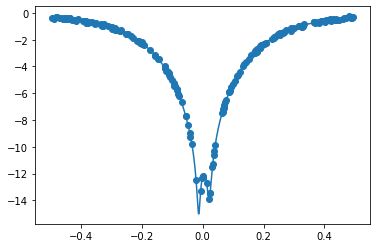

In [38]:
num = torch.argmax(((Y[:4096*2] - pred_ir)**2)[:,0])
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])

Ground Truth: [-0.25503131 -0.47437001]
Reg Pred [-0.36345115 -0.33493036]
Reg MSE [0.01175486 0.01944341]
Irr Pred [-1.7012384  0.3931868]
Irr MSE [2.09151493 0.75265482]


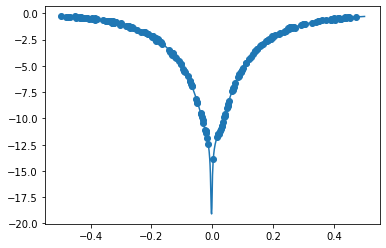

In [39]:
num = torch.argmax(((Y[:4096*2] - pred_ir)**2)[:,1])
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])

# LZR's results
## mse on ideal

loss(mse): 0.1

log10q: 0.3^2=0.09, log10s: 0.18^2=0.0324

## mse on realistic

loss(mse): 0.1

log10q: 0.0846, log10s: 0.0176

u0cos: 0.037, u0sin: 0.040

u0: 0.0176, alpha: 7441.306

# Generative ODE

In [5]:
from model.gen_ode import GenODE

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
input_dim = Y.shape[-1]
output_dim = X_even.shape[-1] - 1

checkpt = torch.load('/work/hmzhao/experiments/experiment_91672.ckpt')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

model = GenODE(ckpt_args, input_dim, output_dim, device).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

GenODE(
  (aug_net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=7, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (1): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()
      (linear3): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()
      (linear3): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()

In [24]:
model.eval()
num = 9
pred = model(torch.tensor(Y[num].reshape(1, -1)).float().to(device), torch.tensor(X_even[0, :, 0]).float().to(device))

/var/tmp/pbs.76146.metis/ipykernel_2237054/2281277329.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(Y[num].reshape(1, -1)).float().to(device), torch.tensor(X_even[0, :, 0]).float().to(device))


tensor([ 0.0000, 50.0000,  1.8059, -0.8079,  0.0583,  0.9828, -1.4816],
       dtype=torch.float64)


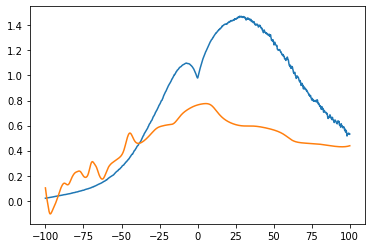

In [25]:
print(Y[num])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.plot(X_even[num, :, 0], pred.detach().cpu().numpy().flatten())

In [26]:
latent = model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device))
print(latent)

tensor([[ 0.3719,  0.5745, -0.5689, -0.7571, -0.3540, -0.3572, -0.5003,  0.0472,
         -0.4456, -0.8231,  0.0650, -0.1645, -0.0868, -0.0801,  0.0713,  0.4275,
          0.1516,  0.3267, -0.3136, -0.2969,  0.2027, -0.5207, -0.5530,  0.4291,
          0.1795,  0.7403,  0.0014,  0.6046, -0.4481, -0.0197,  0.3870,  0.1702]],
       device='cuda:2', grad_fn=<TanhBackward>)


/var/tmp/pbs.76146.metis/ipykernel_2237054/3264624822.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent = model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device))


In [27]:
initial_grad = model.ode_func(torch.tensor(-100).to(device), model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device)))
print(initial_grad)

tensor([[ 0.6530, -0.0379, -0.8157, -0.6468, -0.0016,  0.4780, -0.6244,  0.7381,
         -0.3112, -0.7349, -0.6113, -0.1776,  0.2895,  0.5952,  0.1046, -0.0942,
          0.5388,  0.1250, -0.4205, -0.4357,  0.1152, -0.4637,  0.3835, -0.2316,
         -0.0043,  0.0744,  0.5310, -0.1046,  0.2542,  0.4332, -0.1092,  0.8952]],
       device='cuda:2', grad_fn=<TanhBackward>)


/var/tmp/pbs.76146.metis/ipykernel_2237054/837117711.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_grad = model.ode_func(torch.tensor(-100).to(device), model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device)))


In [28]:
from torchdiffeq import odeint
sol = odeint(model.ode_func, latent, torch.tensor(X_even[0, :, 0]).float().to(device), method="dopri5",
            rtol=1e-7, atol=1e-9)

/var/tmp/pbs.76146.metis/ipykernel_2237054/3534019619.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sol = odeint(model.ode_func, latent, torch.tensor(X_even[0, :, 0]).float().to(device), method="dopri5",


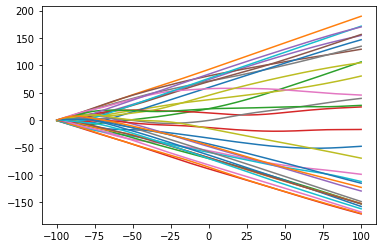

In [29]:
plt.plot(X_even[0, :, 0], sol.squeeze(1).detach().cpu())
plt.show()